In [1]:
%load_ext autoreload
%autoreload 2
import sys
# remove last element from path
import os
from os.path import abspath, join, exists
sys.path.pop()  # preexisting imports path messing up imports
sys.path.append(abspath(join('..')))  # ,'src'
print("\n".join(sys.path))

/home/petrmiculek/Code/kaggle/sentinel_clouds/notebooks
/usr/lib/python310.zip
/usr/lib/python3.10
/usr/lib/python3.10/lib-dynload

/home/petrmiculek/.local/share/virtualenvs/kaggle-DjzpaDb6/lib/python3.10/site-packages
/home/petrmiculek/Code/kaggle/sentinel_clouds


In [44]:
# standard library
from copy import deepcopy
# external
import numpy as np
import torch
from torch import sigmoid
from tqdm.auto import tqdm
from torchinfo import summary
import wandb as wb
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
# local
from src.data.dataset import get_loaders, get_loaders_processed, CloudProcessedDataset
# from src.models.unet import UNet
from src.models.losses import DiceAndBCELogitLoss
from src.models.evaluation import evaluate_metrics, evaluate_get_preds, compute_metrics_own
# from src.models.util import keys_append, print_dict
from src.data.tiling import untile

In [3]:
# weights and biases: list existing runs in the project
wb.login()
wb_api = wb.Api()
entity = 'petrmiculek'
project = 'clouds'
# run_name = 'wise-cloud-84'
run_name = 'hopeful-sun-87'

runs = wb_api.runs(f'{entity}/{project}')  # , order='Accuracy Training'  # /{run_name}
run = None
for r in runs:
    if r.displayName == run_name:
        run = r
        break
print(run.config)
print(run.summaryMetrics)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: petrmiculek. Use `wandb login --relogin` to force relogin


{'lr': 0.0001, 'loss': 'mcc', 'optim': 'AdamW', 'epochs': 77, 'workers': 4, 'backbone': 'resnet18', 'scheduler': 'CosineLRScheduler', 'tile_size': 224, 'batch_size': 64, 'bce_factor': 1, 'pos_weight': None, 'train_size': 6560, 'dice_factor': 1, 'model_bytes': 57325380, 'architecture': 'Unet', 'model_params': 14331345, 'crop_pad_mask': 'crop'}
{'F1 Training': 0.6288316597058935, 'F1 Validation': 0.5844770669937134, 'IoU Validation': 0.5594707268934983, 'Dice Validation': 0.5844770899185767, 'Recall Training': 0.6241775042223698, 'Precision Training': 0.6405252524949971, '_step': 76, '_timestamp': 1700400968.6250908, 'Accuracy Validation': 0.9256053200134864, 'Precision Validation': 0.60698369374642, 'Loss Validation': 0.7103564464128934, 'BCELoss Training': 0.24371619016221427, 'Recall Validation': 0.5910785519159757, 'IoU Training': 0.610740484543217, 'Learning Rate': 3.6650783682323466e-07, 'Grad Training': 2.4900878531840243, 'Loss Training': 0.4083552563074723, 'Training Batch': {'_

In [5]:
# path_data = '/mnt/sdb1/code/sentinel2/interim'
path_processed = '/mnt/sdb1/code/sentinel2/processed'
dataset_kwargs = {'tile_size': 224, 'crop_pad_mask': 'crop'}
loader_kwargs = {'batch_size': 16, 'num_workers': 0, 'pin_memory': True, 'shuffle': False}
# loader = get_loaders(path_data, **dataset_kwargs, **loader_kwargs)
path_out_val = join(path_processed, 'val.npz')
loader = get_loaders_processed(path_processed, splits=['test', 'val'], **dataset_kwargs, **loader_kwargs)
loader['train'] = loader['test']  # TODO: debug, remove

Ignoring dataset args: {'num_workers': 0, 'pin_memory': True, 'shuffle': False}, loading dataset already processed.


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_model = join('/home/petrmiculek/Code/kaggle/sentinel_clouds/src', 'runs', run_name, 'model_checkpoint.pt')
os.path.exists(path_model)
weights = torch.load(path_model, map_location=device)
model = getattr(smp, run.config['architecture'])(encoder_name=run.config['backbone'], encoder_weights=None, in_channels=4, classes=1).to(device)
model = model.eval()
weights.keys()

odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.1.conv1.weight', 'encoder.layer1.1.bn1.weight', 'encoder.layer1.1.bn1.bias', 'encoder.layer1.1.bn1.running_mean', 'encoder.layer1.1.bn1.running_var', 'encoder.layer1.1.bn1.num_batches_tracked', 'encoder.layer1.1.conv2.weight', 'encoder.layer1.1.bn2.weight', 'encoder.layer1.1.bn2.bias', 'encoder.layer1.1.bn2.running_mean', 'encoder.layer1.1.bn2.running_var', 'encoder.layer1.1.bn2.num_batches_tr

In [6]:
[x[0] for x in model.named_parameters()][:10]

['encoder.conv1.weight',
 'encoder.bn1.weight',
 'encoder.bn1.bias',
 'encoder.layer1.0.conv1.weight',
 'encoder.layer1.0.bn1.weight',
 'encoder.layer1.0.bn1.bias',
 'encoder.layer1.0.conv2.weight',
 'encoder.layer1.0.bn2.weight',
 'encoder.layer1.0.bn2.bias',
 'encoder.layer1.1.conv1.weight']

In [7]:
model.__dict__

{'training': False,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('encoder',
               ResNetEncoder(
                 (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
                 (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                 (relu): ReLU(inplace=True)
                 (maxpool): MaxPool2d(kernel_size=3, stride=2, paddin

In [8]:
weights_wrong = model.load_state_dict(weights, strict=False)
model_summary = summary(model, input_size=(1, 4, 224, 224))
# print(model_summary)  # todo shorter summary
criterion = DiceAndBCELogitLoss(bce_factor=run.config['bce_factor'], dice_factor=run.config['dice_factor'], choice=run.config['loss'])
print(weights_wrong)

<All keys matched successfully>


In [41]:
sums = [s['image'][0, :3].mean().item() for s in loader['test']]
print(sums)

[0.09376436471939087, 0.09371019899845123, 0.09394791722297668, 0.09378497302532196, 0.09300350397825241, 0.09316148608922958, 0.09391490370035172, 0.09380681812763214, 0.09253592789173126, 0.0932852178812027, 0.09408587962388992, 0.09439273178577423, 0.09298306703567505, 0.09365123510360718, 0.09335844963788986, 0.09401264041662216, 0.11214243620634079, 0.10311023890972137, 0.1040978655219078, 0.10723424702882767, 0.110191710293293, 0.10928619652986526, 0.1079673245549202, 0.10501191020011902, 0.10815075039863586, 0.1054837629199028, 0.10553839057683945, 0.11329981684684753, 0.10025426000356674, 0.10177778452634811, 0.10892870277166367, 0.11071446537971497, 0.08837366104125977, 0.09251309186220169, 0.09490799903869629, 0.09501337260007858, 0.09215813875198364, 0.09264949709177017, 0.09553733468055725, 0.09737793356180191, 0.08843786269426346, 0.08967768400907516, 0.09272497892379761, 0.0922834724187851, 0.08806978911161423, 0.08877459913492203, 0.08863548189401627, 0.09012667089700699

Compare fresh evaluation with metrics logged in W\&B

In [20]:
results_val = evaluate_metrics(model, loader['val'], criterion, device=device)
print('Metric: (logged, computed)')
{x: (run.summaryMetrics[x + ' Validation'], results_val[x]) for x in results_val.keys()}

  0%|          | 0/816 [00:00<?, ?it/s]

Metric: (logged, computed)


{'Accuracy': (0.9256053200134864, 0.9301432240916648),
 'Precision': (0.60698369374642, 0.6018875977080076),
 'Recall': (0.5910785519159757, 0.5603613926501995),
 'Dice': (0.5844770899185767, 0.5616810345545673),
 'F1': (0.5844770669937134, 0.561681016045405),
 'IoU': (0.5594707268934983, 0.5364451623925418),
 'Loss': (0.7103564464128934, 1.2443042534093063)}

In [21]:
{x: results_val[x] for x in results_val.keys()}

{'Accuracy': 0.9301432240916648,
 'Precision': 0.6018875977080076,
 'Recall': 0.5603613926501995,
 'Dice': 0.5616810345545673,
 'F1': 0.561681016045405,
 'IoU': 0.5364451623925418,
 'Loss': 1.2443042534093063}

In [22]:
results_test = evaluate_metrics(model, loader['test'], criterion, device=device)
results_test

  0%|          | 0/832 [00:00<?, ?it/s]

{'Accuracy': 0.9196310955870283,
 'Precision': 0.567787102515968,
 'Recall': 0.5354736047440662,
 'Dice': 0.5347827378390312,
 'F1': 0.5347827246835357,
 'IoU': 0.5167896842019957,
 'Loss': 1.33989123820972}

In [23]:
loader_iter = iter(loader['test'])

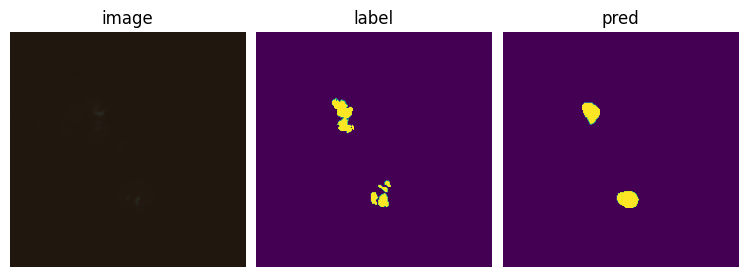

In [42]:
# Per-tile plotting
from src.visualization.visualize import plot_many
batch = next(loader_iter)
logits = model(batch['image'].to(device))
pred = sigmoid(logits)
for i in range(len(batch['image'])):
    # print(batch['image'][i:i+1].sum().item())
    pred_hard = (pred[i:i+1] > 0.5).float().cpu().numpy()
    label = (batch['label'][i:i+1] > 0.5).float().cpu().numpy()
    img_np = batch['image'][i, :3].cpu().numpy().transpose(1, 2, 0)
    # canvas = np.c_[img_np, label[0, 0, :, :], pred_hard[0, 0, :, :]]
    plot_many([img_np, label[0, 0, :, :], pred_hard[0, 0, :, :]], vmin=0, vmax=1, titles=['image', 'label', 'pred'])
    # plt.imshow(canvas)
    # plt.show()

In [67]:
test_preds = evaluate_get_preds(model, loader['test'], device=device)

  0%|          | 0/832 [00:00<?, ?it/s]

In [66]:
n_tiles = 4
tile_size = 224
it = iter(range(len(loader['test']) // (n_tiles ** 2)) )
untile_kw = {'n_tiles': n_tiles, 'tile_size': tile_size, 'hwc': True}

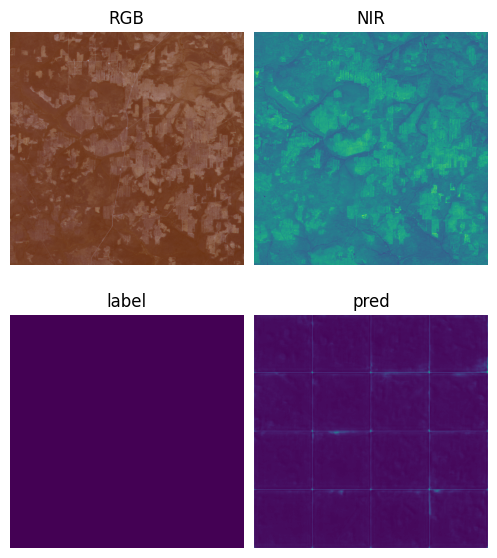

In [70]:
i = next(it)
from_, to_ = i * (n_tiles ** 2), (i + 1) * (n_tiles **2)
pred_group = untile(test_preds['Preds'][from_:to_], **untile_kw)
label_group = untile(test_preds['Labels'][from_:to_], **untile_kw)
img_group = untile(loader['test'].dataset.images[from_:to_], **untile_kw)
img = img_group[:, :, :3]
img = (img - img.min()) / (img.max() - img.min())
plot_many([img, img_group[:, :, 3], label_group, pred_group], titles=['RGB', 'NIR', 'label', 'pred'])


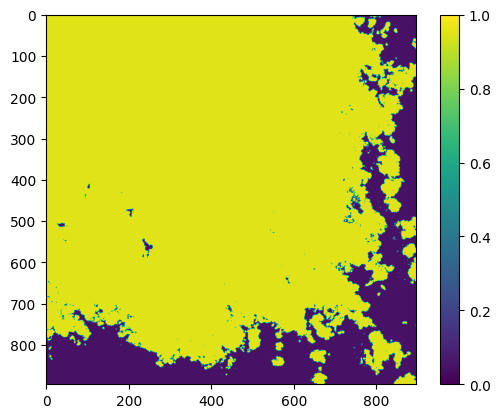

In [84]:
lc = untile(...)
plt.imshow(lc[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

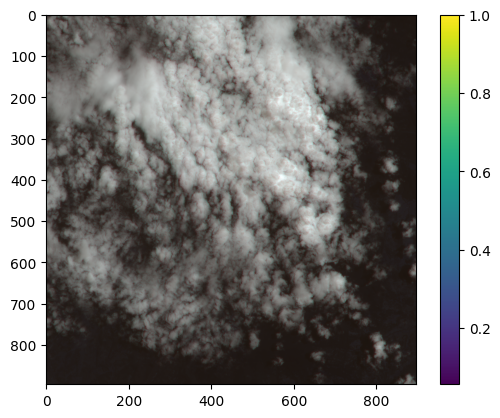

In [91]:
ic = untile(batch['image'].cpu().numpy(), 4, 224, hwc=True)
plt.imshow(ic[..., :3])  # , vmin=0, vmax=1
plt.colorbar()
plt.show()

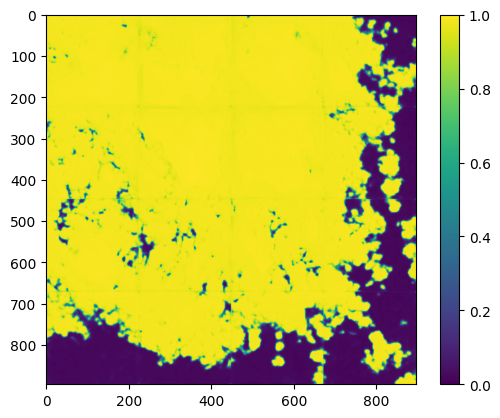

In [90]:
pc = untile(pred.detach().cpu().numpy(), 4, 224, hwc=True)
plt.imshow(pc[...], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [71]:
dummy_input = torch.randn(1, 4, 224, 224, device='cuda')
torch.onnx.export(model, dummy_input, "model.onnx", verbose=True, opset_version=11, input_names=['input'], output_names=['output'])

/home/petrmiculek/.local/share/virtualenvs/kaggle-DjzpaDb6/lib/python3.10/site-packages/segmentation_models_pytorch/base/model.py:16: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:


Exported graph: graph(%input : Float(1, 4, 224, 224, strides=[200704, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %segmentation_head.0.weight : Float(1, 16, 3, 3, strides=[144, 9, 3, 1], requires_grad=1, device=cuda:0),
      %segmentation_head.0.bias : Float(1, strides=[1], requires_grad=1, device=cuda:0),
      %onnx::Conv_310 : Float(64, 4, 7, 7, strides=[196, 49, 7, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_311 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_313 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_314 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_316 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_317 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %onnx::Conv_319 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %onnx::Conv_320 : Float(64, st

In [76]:
import onnx
model2 = onnx.load('model.onnx')
model2.__dict__

mappingproxy({'DESCRIPTOR': <google._upb._message.Descriptor at 0x7fe1ba786ca0>,
              '__module__': 'onnx.onnx_ml_pb2',
              '__slots__': (),
              '__doc__': None})

In [7]:
# run prediction with model2 on dummy output
import onnxruntime
ort_session = onnxruntime.InferenceSession("model.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: dummy_input.cpu().numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

NameError: name 'dummy_input' is not defined

In [82]:
# download model from dropbox
# https://www.dropbox.com/scl/fi/5wpsb1lg4i40duey1v67c/model.onnx?rlkey=b7jovd6arydb7mwzkl30eckpb&dl=0

!curl -L "https://www.dropbox.com/scl/fi/5wpsb1lg4i40duey1v67c/model.onnx?rlkey=b7jovd6arydb7mwzkl30eckpb&dl=0" -o model2.onnx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   256    0   256    0     0    306      0 --:--:-- --:--:-- --:--:--   306
100 55.1M  100 55.1M    0     0  7844k      0  0:00:07  0:00:07 --:--:--  9.8M


In [12]:
from torch.utils.data import Dataset
import numpy as np
class CloudProcessedDataset(Dataset):
    def __init__(self, path_data, **kwargs):
        data = np.load(path_data)
        self.images = data['images']
        self.labels = data['labels']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        x = self.images[index][None, ...]
        y = self.labels[index][None, ...]
        return {'image': x, 'label': y * 0.9 + 0.05}
dataset_iter = iter(CloudProcessedDataset('/mnt/sdb1/code/sentinel2/processed/test.npz'))


In [18]:
sigmoid = lambda x: 1/(1 + np.exp(-x)) 
# dummy input prediction
ort_session = onnxruntime.InferenceSession("model.onnx")
ort_inputs = {ort_session.get_inputs()[0].name: np.ones((1, 4, 224, 224), dtype=np.float32)}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(1, 1, 224, 224)

In [26]:
sample = next(dataset_iter)
ort_inputs = {ort_session.get_inputs()[0].name: sample['image']}
ort_outs = ort_session.run(None, ort_inputs)
pred = sigmoid(ort_outs[0])
# plot image, label, pred
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
img = sample['image'][0, :3].transpose(1, 2, 0)
print(img.shape)
axs[0].imshow(img)
axs[1].imshow(sample['label'][0, 0])
axs[2].imshow(pred[0, 0])
# add titles
axs[0].set_title('Image')
axs[1].set_title('Label')
axs[2].set_title('Prediction')
plt.show()

(224, 224, 3)


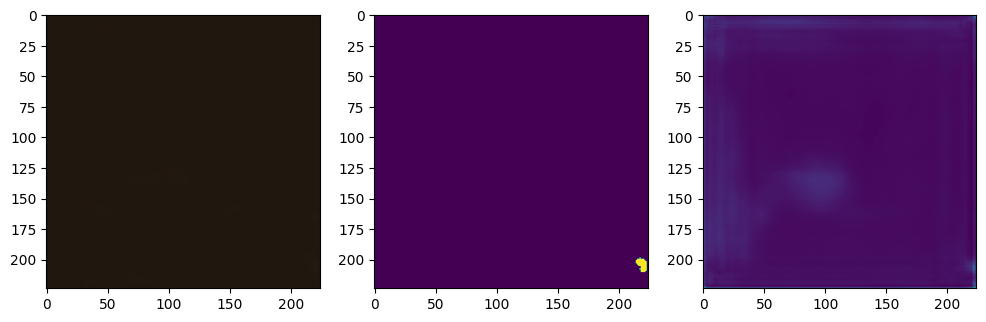